[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/laiadc/DL-schrodinger/blob/main/Random_potentials2D.ipynb)

In [1]:
!git clone https://github.com/laiadc/DL-schrodinger.git

Cloning into 'DL-schrodinger'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 316 (delta 5), reused 7 (delta 3), pack-reused 304
Receiving objects: 100% (316/316), 962.18 MiB | 22.04 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (133/133), done.


In [2]:
cd DL-schrodinger

/content/DL-schrodinger


In [3]:
%tensorflow_version 2.x

# Integrating the Schrödinger equation with Deep Learning in 2D

This notebook extends the work developed in *Random potentials1D.ipynb* by using two-dimensional potentials. In this case, we will train a neural network to  find the stationary states of the Time-Independent Schrödinger equation in 2D:

$$
\Big( - \frac{\hbar^2}{2m} (\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}) + V(x,y) \Big) \phi_n(x,y) = E_n \phi_n(x,y) 
$$

Where $\hbar$ is the reduced Plank constant, $m$ is the mass of the particle, $V(x,y)$ is the potential under which the particle evolves. $\phi_n(x,y)$ is the $n$-th stationary state of the quantum system, with energy $E_n$. The subscrit $n$ can be discrete ($n \in \mathbb{Z}$) or continuous ($n \in \mathbb{R}$).

The stationary wave functions $\phi_n(x,y)$ have a trivial time evolution:

$$
\phi_n(x,y,t) = \phi_n(x,y) e^{-i \frac{E_n}{\hbar}t}
$$

They form a basis of the Hilbert Space of the Hamiltonian of the system

$$
\hat{H} = \frac{\hat{p}^2}{2m} + V(\hat{x,y})
$$

Therefore, the evolution of an arbitrary state of the system $\psi(x,t)$ will be given by:

$$
\psi(x,y,t) = \sum_k c_k \phi_k(x,y) e^{-i \frac{E_k}{\hbar}t} 
$$

Where $c_k$ are linear coefficients and the sum over $k$ can be either discrete or continuous (an integral). The modulus square of the coefficients $|c_k|^2$ represents the probability of being in the $k$-th excited state. 



# Variational method with the H.O basis in 2D

We choose as a basis of $\mathcal{H}$ the eigenfunctions of the Harmonic Oscillator with $m=1$, $\hbar=1$ and $\omega_x=1$, $\omega_y=\omega \in \mathbb{R}-\mathbb{Q}$ in 2D:

\begin{equation}
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}m(x^2 + \omega^2y^2)
\end{equation}

Notice that the angular frequency is different for the two dimensions. Since the H.O is not coupled, the Schrödinger Equation is separable, and thus the eigenfunctions are the product of the 1D eigenfunctions in both axis:

\begin{equation}
\phi_{n_x, n_y}(x,y) = \frac{1}{\sqrt{n_x!2^{n_x} \sqrt{\pi}}}\frac{1}{\sqrt{n_y!2^{n_y} \sqrt{\pi/\omega}}} e^{-x^2/2}e^{-y^2\omega/2} H_{n_x}(x)H_{n_y}(\sqrt{\omega}y) = \phi_{n_x}(x)\phi_{n_y,\omega}(y)
\end{equation}

Where $H_n(x)$ is the $n$th Hermite polynomial. Notice that $n_x$ is the energy level in direction $x$ and $n_y$ is the energy level in direction $y$. 

The energy of an eigenstate with energy levels $n_x$ and $n_y$ is:

\begin{equation}
E_{n_x, n_y} = \hbar (n_x + \omega n_y +1) 
\end{equation}


Since $\omega \in \mathbb{R}-\mathbb{Q}$ there is no degeneracy of energy, and so the energy levels can be ordered in an ascending mode. Therefore, there exists a unique bijective order $n(n_x,n_y)$ which sorts the energy levels. Hence we can write $\phi_{n_x,n_y}(x,y) = \phi_n(x,y)$ where $n = n(n_x,n_y)$. Since $\{\phi_n(x,y)\}_n$ form a basis of $\mathcal{H}$, we can write any wavefunction $\psi(x,y)$ as a linear combination of the eigenfunctions:

\begin{equation}
\psi(x,y) = \sum_{n=0}^\infty a_n \phi_n(x,y)
\end{equation}


Thus, the mean energy of $\psi$ is

\begin{multline}
<H>= <\psi|H|\psi>= \int_{-\infty}^\infty\int_{-\infty}^\infty \Big(\sum_{n=0}^\infty a_n \phi_n(x,y)\Big) \hat{H} \Big(\sum_{m=0}^\infty a_m \phi_{m,\omega}(x,y)\Big) dx dy=\\
\sum_{n=0}^\infty \sum_{m=0}^\infty a_n a_m\int_{-\infty}^\infty \int_{-\infty}^\infty \phi_n(x,y) H(x,y) \phi_{m,\omega}(x,y)dx = \sum_{n=0}^\infty \sum_{m=0}^\infty a_n a_m C_{nm}
\end{multline}



where

\begin{multline}
C_{nm} = \int_{-\infty}^\infty \int_{-\infty}^\infty A_n e^{-x^2/2} H_{n_x}(x)e^{-y^2\omega/2} H_{n_y}(\sqrt{\omega}y) \Big(-\frac{1}{2} \frac{\partial^2}{\partial x^2} -\frac{1}{2} \frac{\partial^2}{\partial y^2} + V(x,y) \Big)\cdot \\ A_m e^{-x^2/2}e^{-y^2\omega/2} H_{m_x}(x) H_{m_y}(\sqrt{\omega}y) dx dy, \qquad A_n = \frac{1}{\sqrt{n_x!2^{n_x} \sqrt{\pi}}}, \ A_m = \frac{1}{\sqrt{n_y!2^{n_y} \sqrt{\pi/\omega}}}
\end{multline}



In [4]:
#@title Code to calculate the order of eigenstates
#@markdown Double click to see the code

import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema


def get_nx_ny(n):
  s=0
  i=-1 
  while s<n:
    i+=1
    s+=i+1
  if s==n:
    N=i+1
  else:
    s-=i+1
    N=i # N= nx+ny
  nx = n-s
  ny = N-nx
  return nx,ny


def get_n(nx,ny):
  return np.sum([i+1 for i in range(nx+ny)]) + nx

## Calculating $C_{nm}$
Given the potential:

\begin{equation}
V(x,y) = \sum_{j+j\leq k} \alpha_{ij} x^i y^j
\end{equation}


Recall that:

\begin{equation}
\frac{\partial^2}{\partial x^2}(H_m(x) e^{-x^2/2} ) = e^{-x^2/2}\Big((x^2-1) H_m(x) - 4mx H_{m-1}(x) + 4m(m-1)H_{m-2}(x)\Big) := e^{-x^2/2} P_m(x)
\end{equation}

We define a new variable $\tilde{y} = \sqrt{\omega}y$ so that the expression of $C_{nm}$ becomes:

\begin{multline}
C_{nm} = \int_{-\infty}^\infty \int_{-\infty}^\infty A_n e^{-x^2/2} H_{n_x}(x)e^{-\tilde{y}^2/2} H_{n_y}(\tilde{y}) \Big(-\frac{1}{2} \frac{\partial^2}{\partial x^2} -\frac{\omega}{2} \frac{\partial^2}{\partial \tilde{y}^2} + V(x,\tilde{y}/\sqrt{\omega}) \Big)\cdot \\ A_m e^{-x^2/2}e^{-\tilde{y}^2/2} H_{m_x}(x) H_{m_y}(\tilde{y}) dx d\tilde{y}
\end{multline}

Finally, we obtain
\begin{multline}
C_{nm} = A_n A_m \Big( - \frac{1}{2} \int_{-\infty}^\infty e^{-\tilde{y}^2} H_{n_y}(\tilde{y}) H_{m_y}(\tilde{y}) d\tilde{y}\int_{-\infty}^\infty  H_{n_x}(x) P_{m_x}(x) e^{-x^2} dx - \\
\frac{\omega}{2} \int_{-\infty}^\infty e^{-x^2} H_{n_x}(x) H_{m_x}(x) dx\int_{-\infty}^\infty  H_{n_y}(\tilde{y}) P_{m_y}(\tilde{y}) e^{-\tilde{y}^2} d\tilde{y} \ + \\
 \int_{-\infty}^\infty \int_{-\infty}^\infty e^{-x^2-\tilde{y}^2} H_{n_x}(x)H_{n_y}(\tilde{y})H_{m_x}(x)H_{m_y}(\tilde{y})V(x,\tilde{y}/\sqrt{\omega}) dxd\tilde{y}\Big) = \\
A_nA_m\Big( \sqrt{\pi}2^{n_y}n_y! \delta_{n_ym_y}I_P(n_x,m_x) + \omega\sqrt{\pi}2^{n_x}n_x! \delta_{n_xm_x}I_P(n_y,m_y) + \sum_{i+j\leq k} \alpha_{ij} \omega^{-j/2} I(n_x, m_x, i)I(n_y,m_y,j) \Big)
\end{multline}

Where $I_P(n,m)$ is:

$$
I_P(n,m) = - \frac{1}{2} I(n,m,2) + 1/2 I(n,m,0) + 2mI(n,m-1,1) - 2m(m-1)I(n, m-2, 0)
$$

And recall that

$$
I(n,m,r) = \int_{-\infty}^\infty x^r e^{-x^2} H_n(x) H_m(x) dx
$$







## Code

In the following cell we define a class which calculates the ground state energy and wavefunction of a potential of the form:

$$
V(x,y) = \sum_{i=1}^k \sum_{j=1}^k \alpha_{ij} x^i y^j
$$

The calculation is analytical (by using the Hermite integrals). This class generates random values of $\vec{\alpha}$ following a uniform distribution between $\vec{\alpha}_{min}$ and $\vec{\alpha}_{max}$. Then it calculates the $n_{state}$-th excited state for these potentials. It returns the energy of such states, the coefficients $\{a_n\}$, the potentials $V(x,y)$ and the wavefunctions $\psi(x,y) = \sum_{n=0}^N a_n \phi_n(x,y)$. 

In [5]:
#@title Class to find eigenstates using the H.O basis
#@markdown Double click to see the code
import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema

class eigen_state_potential2D:

  def __init__(self, alpha_min=None, alpha_max=None, N=10):
    '''
    Class to generate data (V(x) and phi(x) ground state) for potentials of the form
    V(x) = sum_i alpha_i x^i, using the H.O basis
    Args:
      alpha_min: vector of length N, with the minimum value of the coefficients alpha
      alpha_max: vector of length N, with the maximum value of the coefficients alpha
      the values of alpha will be randomly distributed in [alpha_min, alpha_max]
    '''
    if len(alpha_min)!=len(alpha_max):
      print("Error. Inconsisten shapes")
    self.alpha_min = np.array(alpha_min)
    self.alpha_max = np.array(alpha_max)
    self.N = N # Length of H.O basis
    self.k = len(alpha_min) #Number of alphas for V(x)

  def I_nmr(self,n,m,r):
    '''
    Calculates the value of the integral of the Hermitte polynomials
    Args:
      n (int): n of I(n,m,r)
      m (int): m of I(n,m,r)
      r (int): r of I(n,m,r)
    Returns:
      I(n,m,r)
    '''
    if r<0 or n<0 or m<0:
      return 0
    if r==0:
      if n==m:
        return np.sqrt(np.pi)*2**n*factorial(n)
      else:
        return 0
    return 1./2*self.I_nmr(n+1,m,r-1) + n*self.I_nmr(n-1,m,r-1)


  def int_P(self,n,m):
    I1 = -1/2*self.I_nmr(n,m,2)
    I2 = 1/2*self.I_nmr(n,m,0)
    I3 = 2*m*self.I_nmr(n,m-1,1)
    I4 = -2*m*(m-1)*self.I_nmr(n, m-2,0)
    return I1 + I2 + I3 + I4


  def C_nm(self,n,m, alphas):
    '''
    Calculates the coefficient C_{nm} for the potential V(x,y) = \sum_i \sum_j alpha[i,j]x^iy^j
    Args:
      n (int): n of C_nm
      m (int): m of C_nm
      alphas (np.array): size kxk. Coefficients of the potential V(x,y)
    Returns:
      C_{nm}
    '''
    # Given n and m find nx, ny, mx, my
    nx, ny = get_nx_ny(n)
    mx, my = get_nx_ny(m)

    # Find the normalization constants
    anx = np.sqrt(np.pi)*factorial(nx)*2**nx
    any = np.sqrt(np.pi)*factorial(ny)*2**ny
    amx = np.sqrt(np.pi)*factorial(mx)*2**mx
    amy = np.sqrt(np.pi)*factorial(my)*2**my
    A = 1./np.sqrt(anx*any*amx*amy)

    # Calculate integrals
    #Ix
    if ny==my:
      Ix = any*self.int_P(nx,mx)
    else:
      Ix = 0
    #Iy
    if nx==mx:
      Iy = anx*self.int_P(ny,my)
    else:
      Iy = 0
    #Iv
    Iv = 0
    for i in range(alphas.shape[0]):
      for j in range(alphas.shape[1]):
        Iv+=alphas[i,j]*self.I_nmr(nx,mx,i)*self.I_nmr(ny,my,j)
    return A*(Ix+Iy+Iv)

  def find_eigen_state(self,alphas, n_state=0):
    '''
    Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
    Args:
      alphas(np array): size kxk. Coefficients of the potential V(x)
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E_a (float): Energy of the ground state for potential V
      a (np.array): size N. Coefficients in the basis of the H.O potential
    '''
    N = self.N
    # 0. Generate matrix of C_nm
    C = np.zeros((N,N))
    for n in range(N):
      for m in range(N):
        C[n,m] = self.C_nm(n,m,alphas)

    # 1. Generate matrix D
    D = np.zeros((N,N))
    for n in range(N):
      for m in range(n+1):
        D[n,m] = C[n,m] + C[m,n]
        D[m,n] = D[n,m]

    # 2. Diagonalize matrix D
    vaps, veps = eigh(D)

    # 3. Calculate <H> for all a
    Hs = np.zeros(N)
    for i in range(N):
      a = veps[:, i]
      for n in range(N):
        for m in range(N):
          Hs[i]+=a[n]*a[m]*C[n,m]

    # 4. We choose the vector which minimizes <H>
    # If n_state!=0, we choose the vector with n_state-th lowest energy
    # as an approximation of the n_state excited state 
    sel = np.argsort(Hs)[n_state]#np.argmin(Hs)
    a = veps[:, sel] # Final value of eigenvalues for state n_state
    E_a = Hs[sel] # Value of the energy
    return E_a, a

  def generate_data(self,n_samples, alpha=np.array([None]), n_state=0, display=50):
    '''
    Generates samples of potentials  with random coefficients and finds the n_state excited state for them
    Args:
      n_samples (int): Number of samples of potentials (alphas)
      alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
      n_state (int): Number of excited state (default n_state=0, ground state)
      display (int): Display step
    Returns:
      E (np.array): size n_samples. Ground energy for each V
      a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      alpha (np.array): size n_samples x k x k. Coefficients of the potentials V(x,y)
    '''
    data = np.zeros((n_samples, self.N))

    # Generate random value of alphas
    if (alpha==None).any():
      print("Random alphas")
      r_alpha = np.random.random((n_samples, self.k,self.k)) # Values between 0 and 1
      alpha = r_alpha*(self.alpha_max - self.alpha_min)+ self.alpha_min # random alpha
    
    # Prepare vectors of energies and coefficients
    E = np.zeros(n_samples)
    a = np.zeros((n_samples, self.N))
    # Find ground state for each sample
    for i in range(n_samples):
      if i%display==0:
        print("\rGenerating data: {}/{}".format(i,n_samples), end='')
      E_new, a_new = self.find_eigen_state(alpha[i,:,:], n_state)
      E[i] = E_new
      if a_new[0]<0:
        a[i,:] = -a_new
      else:
        a[i,:] = a_new
    return E, a, alpha   

  def evaluate_potential(self,xmin, xmax, n_points, alpha):
    '''
    Given the coeefficients alphas, it evaluates the potential in V(x)
    Args:
      xmin(float): minimum value of x
      xmax (float): maximum value of x
      n_points (int): Number of points between xmin and xmax
      alpha (np.array): size n_samples x k x k. Matrix of coefficients of V(x) (each row a different potential)
    Returns:
      V(np.array): size n_samples x n_points x n_points. V(x) for every sample
      x(np.array): size n_points. Values of x and y
    '''
    x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    y = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    n_samples, k,_ = alpha.shape
    V = np.zeros((n_samples, n_points, n_points))# V(x,y) in each row different alpha
    x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
    y_mat = (y**np.arange(k)[:,None])# Matrix of powers of y: y^0, y^1, y^2, ..., y^N (in every row)

    for n in range(n_samples):
      for i in range(n_points):
        for j in range(n_points):
          V[n,i,j] = np.sum(alpha[n,:,:]*np.outer(x_mat[:,i], y_mat[:,j]).T)
    
    return V, x

  def HO_wavefunction(self,n, xmin, xmax, n_points):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      herm = eval_hermite(n, x) # H_n(x)
      exp = np.exp(- x**2/2) # Exponential term
      phi_n = exp*herm
      
      # Normalization
      h = (xmax - xmin)/n_points
      C = 1./np.sqrt(np.sum(phi_n*phi_n*h))
      phi_n = C*phi_n

      return phi_n

  def final_wavefunction(self, xmin, xmax, n_points, a):
      '''
      Returns the final wavefunctions psi(x) = sum_i alpha_i phi_i(x) for each alpha.
      Args:
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
        a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      Returns:
        waves(np.array): size n_samples x n_points x n_points. psi(x,y) for each value of V (given by alpha)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      y = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      n_samples, _ = a.shape
      # Construct matrix of phi_n
      phis = np.zeros((self.N, n_points, n_points))
      for i in range(self.N):
        nx,ny = get_nx_ny(i)
        phis[i,:,:] = np.outer(self.HO_wavefunction(nx, xmin, xmax, n_points), self.HO_wavefunction(ny, xmin, xmax, n_points))
      
      waves = np.zeros((n_samples, n_points, n_points))
      for n in range(n_samples):
        waves[n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      return waves, x, phis


## Example of 2D potential

In [6]:
#@title Generate data

#@markdown Double click to see the code


#@markdown ---
#@markdown ### Enter parameters:
xmin = -5#@param {type:"number"}
xmax = 5#@param {type:"number"}
N=10#@param {type:"slider", min:5, max:30, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=2#@param {type:"integer"}
#@markdown ---
alpha_min = np.array([[0,0,0.2],
                      [0,0,0],
                      [0.2,0,0]])

alpha_max = np.array([[0,0,1.0],
                      [0,0,0],
                      [1.0,0,0]])
k = alpha_min.shape[0]

data_gen = eigen_state_potential2D(alpha_min, alpha_max, N)
E, a, alpha = data_gen.generate_data(n_samples, n_state=n_state)
waves, x, phis = data_gen.final_wavefunction( xmin, xmax, n_points, a)
V, _ = data_gen.evaluate_potential( xmin, xmax, n_points, alpha)

Random alphas
Generating data: 0/2

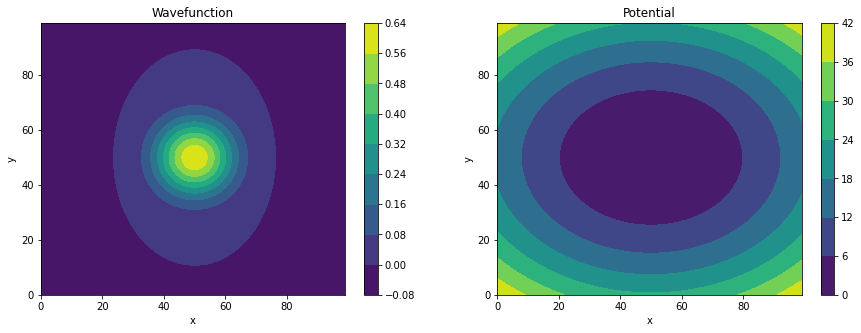

In [7]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx = 1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(V[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

# Ground state potentials

Now that we have generated the code to approximate the eigenstates of a random potential, we are going to generate random potentials of the form:

$$
V(x,y) = \alpha_{00} + \alpha_{10} x + \alpha_{01}y + \alpha_{11}xy + \alpha_{20} x^2 + \alpha_{02}y^2 + \alpha_{21}x^2y + \alpha_{12}xy^2 + \alpha_{03}y^3 + \alpha_{30}x^3 + \alpha_{04}y^4 + \alpha_{13}xy^3 + \alpha_{22}x^2y^2 + \alpha_{31}x^3y + \alpha_{40}x^4
$$

To ensure that the eigenstates have discrete energies (and thus are physical states), we will impose some properties on the coefficients, so that the even terms ($x^2$ and $x^4$) dominate over the odd term ($x^3$). Also, we allow the potential to be negative and non-centered by including negative values of $\alpha_0$ and $\alpha_1$. Finally, we will use small values of the coefficients so that the potential does not achieve very high values, which can lead to numerical unstability.


In [ ]:
#@title Code to generate data

#@markdown Double click to see the code


#@markdown ---
#@markdown ### Enter parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 200#@param {type:"integer"}
n_samples = 100#@param {type:"integer"}
#@markdown ---

alpha_min = np.array([[-150,-10,0.2, -0.05, 0],
                      [-10,-0.1,-0.1, -0.05, 0],
                      [0.2,-0.1,0, 0, 0],
                      [-0.05, -0.05,0,0,0],
                      [0,0,0,0,0]])/50

alpha_max = np.array([[50,5,1.0, 0.05, 0.2],
                      [5,0.1,0.1, 0.05, 0],
                      [1.0,0.1,0.2,0,0],
                      [0.05, 0.05, 0,0,0],
                      [0.2,0,0,0,0]])/50

k = alpha_min.shape[0]

r_alpha = np.random.random((int(n_samples*0.8), k,k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([[-150,-10,0.2,0,0],
                      [-10,-0.1,0,0,0],
                      [0.2,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

alpha_max2 = np.array([[50,5,1.0,0,0],
                      [5,0.1,0,0,0],
                      [1.0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

r_alpha = np.random.random((int(n_samples*0.2), k,k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))


## Convergence of the method

In order to choose the value of $N$, we will generate the ground-state energies for different vales of $N$ and compute the difference. When the value of the energy stabilizes up to certain precision $\gamma$, we will fix the value of $N$. We will evaluate the performance for $n\_samples$ different samples.

In [ ]:
gamma = 0.001
Ns = np.arange(3,51)
Es = np.zeros(( Ns.shape[0], n_samples))

for i in range(Ns.shape[0]):
  print("\nSample {}\{}".format(i, Ns.shape[0]))
  data_gen = eigen_state_potential2D(alpha_min, alpha_max, Ns[i])
  E, a, _ = data_gen.generate_data(n_samples, alpha)
  Es[i,:] = E

In [ ]:
#@title Example energy as a function of N
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ns,
    y=Es[:,0],
    mode="lines",
    name = "sample1")
    )

fig.add_trace(go.Scatter(
    x=Ns,
    y=np.repeat(Es[-1,0], Ns.shape[0]),
    mode="lines",
    name = "sample2")
    )


fig.update_layout(
    title="Energies as a function of N",
    xaxis_title="N")

fig.show()

We see that the energy stabilizes fast. Now, for $\gamma =0.001$, let's see which is the $N$ needed on average to ensure convergence.

In [ ]:
#@title Evolution of difference of energy
gamma=0.02
E_dif = np.abs(Es[:-1,:] - Es[1:,:])

E_dif_mean = np.mean(E_dif, axis=1)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ns[1:],
    y=E_dif_mean,
    mode="lines",
    name = "Difference in energy")
    )
fig.add_trace(go.Scatter(
    x=Ns[:-1:],
    y=np.repeat(gamma, (Ns[1:]).shape[0]),
    mode="lines",
    name = "Gamma")
    )

We see that for $N=32$ the difference in the ground energy is below $\gamma$. Thus, we select this value to generate the wavefunctions. 

## Generating the data to train a neural network model

In [ ]:
#@title Code to generate data

#@markdown Double click to see the code \\
#@markdown **Note: This cell may take some hours to run. 
#@markdown You can skip it and load the generated data instead**


#@markdown ---
#@markdown ### Enter parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---


alpha_min = np.array([[-150,-10,0.2, -0.05, 0],
                      [-10,-0.1,-0.1, -0.05, 0],
                      [0.2,-0.1,0, 0, 0],
                      [-0.05, -0.05,0,0,0],
                      [0,0,0,0,0]])/50

alpha_max = np.array([[50,5,1.0, 0.05, 0.2],
                      [5,0.1,0.1, 0.05, 0],
                      [1.0,0.1,0.2,0,0],
                      [0.05, 0.05, 0,0,0],
                      [0.2,0,0,0,0]])/50

k = alpha_min.shape[0]
r_alpha = np.random.random((int(n_samples*0.8), k,k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([[-0.5,-0.1,0.2,0,0],
                      [-0.1,-0.05,0,0,0],
                      [0.2,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

alpha_max2 = np.array([[0.5,0.5,1.0,0,0],
                      [0.5,0.1,0,0,0],
                      [1.0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])


r_alpha = np.random.random((int(n_samples*0.2), k,k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))


data_gen = eigen_state_potential2D(alpha_min, alpha_max, N)
# Generate the energies, wavefunctions and potentials
E, a, alpha = data_gen.generate_data(n_samples, alpha)
waves, x,phis = data_gen.final_wavefunction( xmin, xmax, n_points, a)
V, _ = data_gen.evaluate_potential( xmin, xmax, n_points, alpha)
idx=-1


In [ ]:
#@title Code to save the generated data
#@markdown Double click to see the code \\
#@markdown **Note: Only run this cell if you have generated new data and want 
#@markdown  to overwrite the previously saved one. Notice that this could alter 
#@markdown the results of the notebook.**
# Save data
with open("./training_data/random_potentials/2D/V.npy", 'wb') as f:
  np.save(f, V)
with open("./training_data/random_potentials/2D/waves.npy", 'wb') as f:
  np.save(f, waves)
with open("./training_data/random_potentials/2D/x.npy", 'wb') as f:
  np.save(f, x)
with open("./training_data/random_potentials/2D/alpha.npy", 'wb') as f:
  np.save(f, alpha)
with open("./training_data/random_potentials/2D/a.npy", 'wb') as f:
  np.save(f, a)

In [8]:
#@title Code to load the data { vertical-output: true }
#@markdown Double click to see the code \\
#@markdown  **Note: Run this cell to load the saved data**
# Load data
with open("./training_data/random_potentials/2D/V.npy", 'rb') as f:
  V = np.load(f)
with open("./training_data/random_potentials/2D/waves.npy", 'rb') as f:
  waves = np.load(f)
with open("./training_data/random_potentials/2D/x.npy", 'rb') as f:
  x = np.load(f)
with open("./training_data/random_potentials/2D/alpha.npy", 'rb') as f:
  alpha = np.load(f)
with open("./training_data/random_potentials/2D/a.npy", 'rb') as f:
  a = np.load(f)

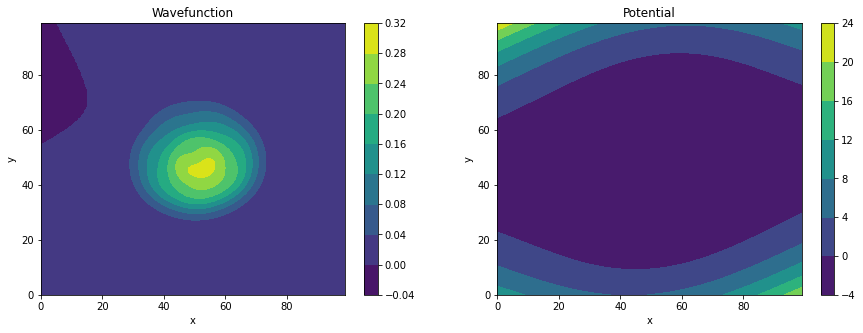

In [9]:
#@title Example of potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx =0
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(V[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

## Training a neural network



In [14]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [15]:
#@title Class to train the network
#@markdown Double click to see the code
class Training():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    '''
    Calculates MSE
    Args:
      y_true (tensor): True values of wavefunctions
      y_pred (tensor): predicted values of wavefunctions
    Returns:
      MSE
    '''
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))#tf.keras.losses.MeanSquaredError(y_true_reshaped, y_pred)


  def loss_val(self, x_val, y_val):
      '''
      Computes the validation loss 
      Args:
        x_val(tensor): batch of validation sample
        y_val (tensor): labels for validation
      Returns:
         val_loss(tensor): validation loss
      '''
      pred_val = self.net(x_val, False)
      val_loss = self.loss( y_val, pred_val)
      return val_loss

  def early_stop(self, epoch, val_loss, stop):
      '''
      Assesses if we have to stop training
      Args:
         epoch (int): current epoch
         val_loss (tensor): current validation loss
         stop (bool): early stop parameter
      Returns:
         stop(bool): True if the models stops training, false if it continues training
      '''
      #Store best validation loss
      if epoch == 0:
          self.best_loss = val_loss
      else:
          if val_loss < self.best_loss:
              self.stopping_step = 0
              self.best_loss = val_loss
          else:
              #If the validation loss does not decrease, we increase the number of stopping steps
              self.stopping_step += 1
      #If such number reaches the maximum, we stop training
      if self.stopping_step == self.early_stopping:
          stop = True
          print('Early stopping was triggered ')
      return stop

    # Optimization process. 
  @tf.function()
  def run_optimization(self,x, y):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
        y (tensor): Labels for training data
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          loss = self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  #@tf.function
  def fit(self, X_train,y_train, X_test,y_test, save=True):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data
      y_train (numpy array): Labels training data
      X_test (numpy array): Processed test data
      y_test (numpy array): Labels test data
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)
    

    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size) 

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters and stop == False:
        for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train)
            loss_batch.append(loss.numpy())

        for (test_x, test_y) in test_data:
            #Compute validation loss
            val_loss = self.loss_val(test_x, test_y)
            val_loss_batch.append(val_loss.numpy())
        
        stop = self.early_stop(epoch, val_loss, stop)
        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Validation loss: ", val_loss.numpy(), "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [16]:
#@title Split training and test data
from sklearn.model_selection import train_test_split

# Split train and test 
idx_train, idx_test, wave_train, wave_test = train_test_split(np.arange(V.shape[0]), waves, test_size=0.33, random_state=123)
V_train = V[idx_train,:]
V_test = V[idx_test,:]

alpha_train = alpha[idx_train]
alpha_test = alpha[idx_test]


In [17]:
#@title Parameters to tran the neural network { output-height: 10 }
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter the data parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the training parameters:
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath = "./trained_models/random_potentials/2D/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.3#@param {type:"number"}
#@markdown ---




In [18]:
#@title Run this cell to load model
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2,
                          n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, 
                 batch_size, display_step, filepath=filepath,
                 early_stopping=100, restore=True)


Restored from ./trained_models/random_potentials/2D/tf_ckpts/ckpt-1


In [ ]:
#@title Run this cell to train the network
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, 
                          n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters,
                 batch_size, display_step, filepath=filepath,
                 early_stopping=100, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  2.465767e-06 Loss:  2.1712472e-06
Epoch:  20 Validation loss:  1.5032363e-06 Loss:  1.6690348e-06
Epoch:  30 Validation loss:  1.4894442e-06 Loss:  1.3491865e-06
Epoch:  40 Validation loss:  1.1839755e-06 Loss:  1.0210193e-06
Epoch:  50 Validation loss:  1.0865033e-06 Loss:  8.2806173e-07
Epoch:  60 Validation loss:  1.2611702e-06 Loss:  5.927573e-07
Epoch:  70 Validation loss:  3.2759291e-07 Loss:  5.8041496e-07
Epoch:  80 Validation loss:  4.8936e-07 Loss:  5.679856e-07
Epoch:  90 Validation loss:  5.198012e-07 Loss:  4.5952532e-07
Epoch:  100 Validation loss:  3.907971e-07 Loss:  5.4915773e-07
Epoch:  110 Validation loss:  8.307619e-07 Loss:  3.1634744e-07
Epoch:  120 Validation loss:  3.569317e-07 Loss:  3.7883873e-07
Epoch:  130 Validation loss:  1.5398498e-07 Loss:  3.3551572e-07
Epoch:  140 Validation loss:  1.1598509e-07 Loss:  2.8657362e-07
Epoch:  150 Validation loss:  3.007656e-07 Loss:  2.53586e-07
Epoch:  160 Validation loss:  3.966612e-07 Loss

In [19]:
#@title Make predictions
pred = conv_model(V_test)
print("Test MSE: %f" % train.loss(pred, wave_test))
pred = pred.numpy().reshape(-1,n_points,n_points)
idx = -1

Test MSE: 0.000000


## Plot the results

We plot the prediction and the real values of the wave function.

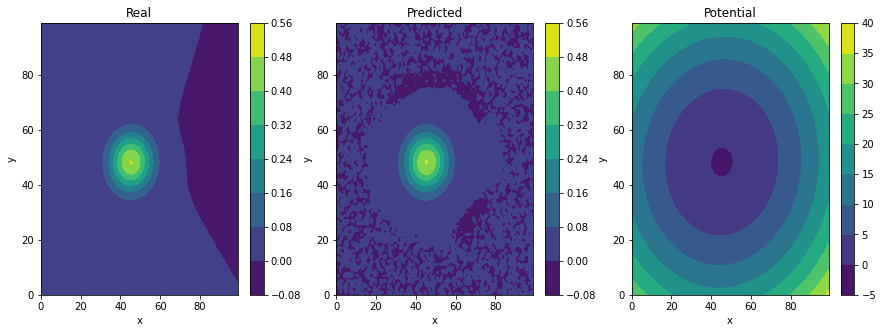

In [20]:
#@title
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))

cs1 = ax1.contourf(wave_test[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(V_test[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [21]:
#@title Code to calculate the empirical energy
#@markdown Double click to show code
def empirical_energy(phi, potential, xmin=-10, xmax = 10,
                       ymin=-10, ymax = 10,
                       n_points=100, hbar=1, m=1):
    '''
    Calculates empirical energy for 2D potentials
    Args:
      phi (np.array): Wavefunction
      potential (np.array): Potentials V(x,y)
      xmin (int): minimum value of x
      xmax (int): maximum value of x
      ymin (int): minimum value of y
      ymax (int): maximum value of y
      n_points (int): number of points in the grid
      hbar (float): h bar
      m (float): mass
    Returns:
      energy (np.array): mean empirical energy for each sample
    '''
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = np.asarray(phi)
    if phi.shape!= potential.shape:
      phi = np.reshape(phi, potential.shape)

    # We first calculate the second derivative of phi
    # derivative x
    phir = phi.copy()
    phir[:,:,0] = 0
    phir[:,:,1:] = phi[:,:,:-1]
    phil = phi.copy()
    phil[:,:,-1] = 0
    phil[:,:,:-1] = phi[:,:,1:]
    deriv_x = (phir - 2*phi + phil)/(h1*h2)

    # derivative y
    phir = phi.copy()
    phir[:,0,:] = 0
    phir[:,1:,:] = phi[:,:-1,:]
    phil = phi.copy()
    phil[:,-1,:] = 0
    phil[:,:-1,:] = phi[:,1:,:]
    deriv_y = (phir - 2*phi + phil)/(h1*h2)

    # Now we calculate the mean energy
    energy = np.sum((-hbar*hbar/(2*m)*phi*(deriv_x + deriv_y) + potential*(phi*phi))*h1*h2, axis=(1,2))
    return energy

In [23]:
E = empirical_energy(wave_test, V_test,xmin=-10, xmax = 10, ymin = -10, ymax = 10, n_points=100)
E_emp = empirical_energy(pred, V_test,xmin=-10, xmax = 10, ymin=-10, ymax=10, n_points= 100)

print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  3.5175417370082486e-05


In [ ]:
#@title Predicted and Real mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Test with Harmonic Oscillator

In [24]:
#@title Class to generate data of the Harmonic Oscillator
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_hermite
import math 

class Harmonic_Oscillator2D:

  def __init__(self, omega_min = 0.001, omega_max = 1, x0_min = -0.5, x0_max = 0.5,
               hbar = 1, m = 1, xmin = -8, xmax = 8, n_points = 200):
    self.omega_min = omega_min # omega ~ U(omega_min, omega_max)
    self.omega_max = omega_max
    self.x0_min = x0_min
    self.x0_max = x0_max
    self.hbar = hbar
    self.m = m
    self.n_points = n_points # Number of points of the grid 
    self.omega_x=np.array([None])
    self.omega_y = np.array([None])
    self.x0 = np.array([None])
    self.y0 = np.array([None])
    self.xmin = xmin
    self.xmax = xmax


  def generate_omega(self, N):
    self.omega_x = np.random.uniform(self.omega_min, self.omega_max, N)
    self.omega_y = np.random.uniform(self.omega_min, self.omega_max, N)
    self.x0 = np.random.uniform(self.x0_min, self.x0_max, N)
    self.y0 = np.random.uniform(self.x0_min, self.x0_max, N)
    
  def order_energy(self,n_state, omegax, omegay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """

    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    nxs = np.zeros((n_state+1)**2)
    nys = np.zeros((n_state+1)**2)
    Es = np.zeros((n_state+1)**2)
    i=0
    for nx in range(n_state+1):
      for ny in range(n_state+1): 
          nxs[i] = nx
          nys[i] = ny
          Es[i] = self.hbar*(omegax*(nx+1/2) + omegay*(ny + 1/2))
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def HO_wavefunction(self,n, x0, omega, n_points):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        x0 (float):  Value of x0
        omega (float): Value of omega
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''

      x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points)
      sigma_inv = np.sqrt(self.m*omega/self.hbar)
      all_x = (x - x0)*sigma_inv # It is a matrix of dim (num_x_points), 
      herm = eval_hermite(n, all_x) # H_n(x/sigma)
      exp = np.exp(- all_x**2/2) # Exponential term
      phi_n = exp*herm

      potential = (x-x0)**2 * 1/2*self.m*omega**2

      return phi_n, potential,x

  def generate_data(self, N=None, n = 0, new_omega=True):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_omega or (self.omega_x==None).any() or (self.omega_y==None).any() or (self.y0==None).any() or (self.x0==None).any():
      self.generate_omega(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,n_points))
    potential_y = np.zeros((N,n_points))
    phi_x = np.zeros((N,n_points))
    phi_y = np.zeros((N,n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)

    for sample in range(N):
      nx, ny = self.order_energy(n, self.omega_x[sample], self.omega_y[sample])
      nxs[sample] = nx
      nys[sample] = ny
      p_x, pot_x, x = self.HO_wavefunction(nx, self.x0[sample], self.omega_x[sample], self.n_points)
      p_y, pot_y, y = self.HO_wavefunction(ny, self.y0[sample], self.omega_y[sample], self.n_points)
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y

    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h = (self.xmax - self.xmin)/self.n_points
    for i in range(N):
      phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
      phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
      phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
      C = 1./np.sqrt(np.sum(phi_i*phi_i*h*h)) # Normalization constant
      phi[i,:,:] = C*phi_i
      # Potential
      pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
      pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
      potential[i,:,:] = pot_x + pot_y

    return phi, x, self.omega_x, self.omega_y, self.x0, self.y0, potential, nxs, nys

  def get_energy(self, n, omega_x=np.array([None]), omega_y=np.array([None])):
    if (omega_x==None).any() or (omega_y==None).any():
      omega_x = self.omega_x
      omega_y = self.omega_y
    nx,ny = get_nx_ny(n)
    E = self.hbar*(omega_x*(nx+1/2) + omega_y*(ny + 1/2))
    return E.flatten()



In [25]:
#@title Generate H.O data { form-width: "30%" }
ho = Harmonic_Oscillator2D(n_points =n_points, xmin=-8, xmax=8, omega_min=0.3, 
                           omega_max = 1.0, x0_min = -0.05, x0_max = 0.05)

phi_0, x, omega_x, omega_y, x0, y0, potential, nxs, nys = ho.generate_data(500,0)

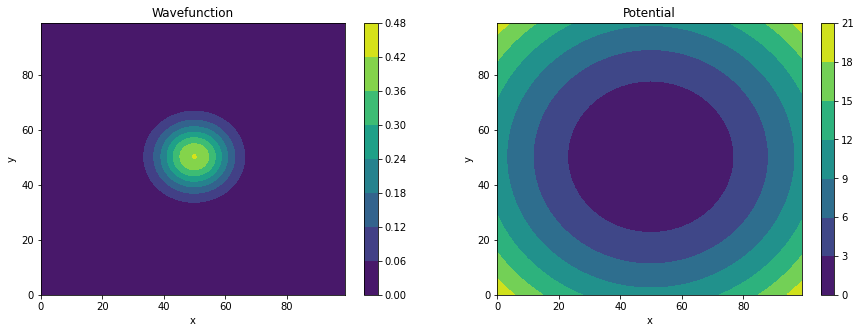

In [26]:
#@title Example of potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

In [27]:
#@title Predict wavefunctions
pred = conv_model(potential)
print("Test MSE: %f" % train.loss(pred, phi_0))
pred = pred.numpy().reshape(-1,n_points, n_points)

Test MSE: 0.000011


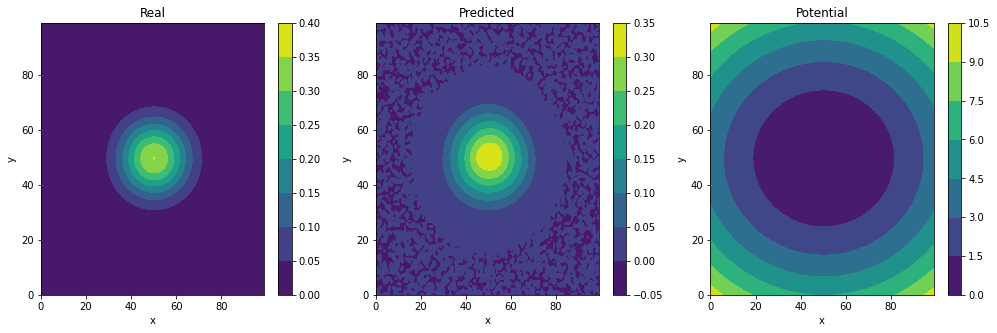

In [28]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [30]:
E = empirical_energy(phi_0, potential,xmin=-10, xmax = 10, n_points=100)
E_emp = empirical_energy(pred, potential,xmin=-10, xmax = 10, n_points= 100)
print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  3.5261500494603186e-05


In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Harmonic oscillator energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Test with Morse potential

In [31]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)

    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    pot = z**(lamb -n -1/2) # Potential term

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    phi_n = pot*exp*laguerre
    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
  
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys


  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [32]:
#@title Generate Morse Data { form-width: "30%" }
n_points=100
morse = Morse2D(n_points = n_points,  x_min = -8, x_max=8,y_min = -8, y_max=8, xe_min =-0.05,
              xe_max = 0.05, a_min = 0.09, a_max = 0.09, De_max = 10, De_min =7)

phi_0, x,y, potential, a_x, a_y, De_x, De_y, xe, ye, nxs, nys = morse.generate_data(500,0, True) 
idx=0

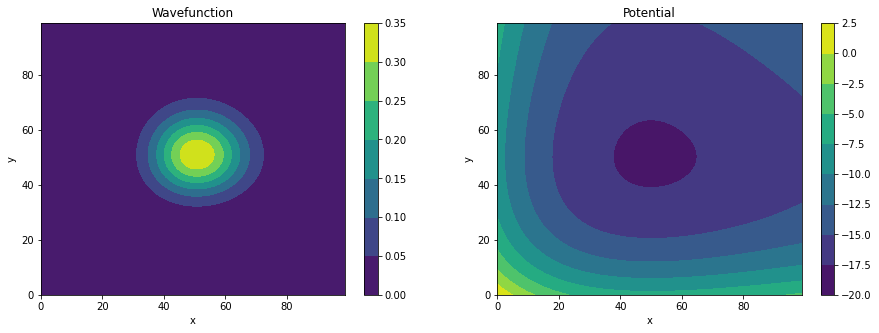

In [33]:
#@title Example of potential and wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

In [34]:
#@title Predict wavefunctions
pred = conv_model(potential)
print("Test MSE: %f" % train.loss(pred, phi_0))
pred = pred.numpy().reshape(-1,n_points, n_points)

Test MSE: 0.000006


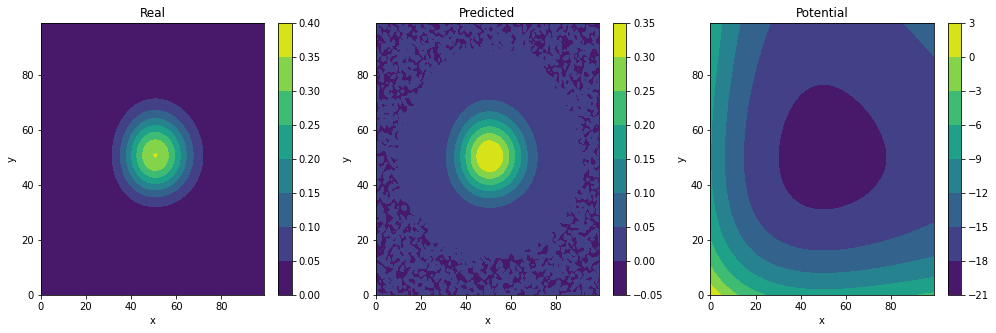

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = empirical_energy(phi_0, potential,xmin=-10, xmax = 10, n_points=100)
E_emp = empirical_energy(pred, potential,xmin=-10, xmax = 10, n_points= 100)
print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  0.00010798170226293741


In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()